## Task 2: Dataset Visualization with FiftyOne

In [1]:
!uv pip install fiftyone==1.11.0

Using Python 3.11.14 environment at: /home/vanessa/.local/micromamba/envs/handsoncv
Resolved 110 packages in 76ms                                        
⠙ Preparing packages... (0/1)                                                   
⠙ Preparing packages... (0/1)-------------------     0 B/10.77 MiB           
⠙ Preparing packages... (0/1)------------------- 16.00 KiB/10.77 MiB         
⠙ Preparing packages... (0/1)------------------- 32.00 KiB/10.77 MiB         
⠙ Preparing packages... (0/1)------------------- 48.00 KiB/10.77 MiB         
⠙ Preparing packages... (0/1)------------------- 60.44 KiB/10.77 MiB         
⠙ Preparing packages... (0/1)------------------- 76.44 KiB/10.77 MiB         
⠙ Preparing packages... (0/1)------------------- 92.44 KiB/10.77 MiB         
⠙ Preparing packages... (0/1)------------------- 108.44 KiB/10.77 MiB        
⠙ Preparing packages... (0/1)------------------- 124.44 KiB/10.77 MiB        
⠙ Preparing packages... (0/1)------------------- 140.44 KiB/10.

In [1]:
import random
import json
import numpy as np
import fiftyone.utils.random as four
import fiftyone.core.expressions as fe
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from handsoncv.datasets import create_lidar_viz

import os
# Set FiftyOne App to work in Remote SSH
os.environ["FIFTYONE_DISABLE_NOTEBOOK_APP"] = "1"

import fiftyone as fo
fo.app_config.enable_notebook_app = True

# Configuration
PATH = "~/Documents/repos/BuildingAIAgentsWithMultimodalModels/data/assessment/"
ROOT_PATH = "~/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/"
# PATH = "~/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/data/" #"~/mnt/gdrive/path/to/your/assessment_folder" # Update this path to where the data is
MOUNTED_PATH = os.path.expanduser(PATH)
MOUNTED_ROOT_PATH = os.path.expanduser(ROOT_PATH)
fiftyone_dataset_name = "cilp_assessment"
PROCESSED_DIR = Path(os.path.join(MOUNTED_PATH, "processed_viz"))
PROCESSED_DIR.mkdir(exist_ok=True)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

###  Requirement 2.1 (Grouped Dataset)

In [2]:
# Cleanup & Initialization
if fiftyone_dataset_name in fo.list_datasets():
    fo.delete_dataset(fiftyone_dataset_name)
    
dataset = fo.Dataset(fiftyone_dataset_name)
dataset.add_group_field("group", default="rgb")

# Process Cubes & Spheres Modalities
classes = ["cubes", "spheres"]
all_pairs = []

for label in classes:
    class_dir = Path(MOUNTED_PATH) / label
    rgb_dir = class_dir / "rgb"
    lidar_dir = class_dir / "lidar"
    
    if not rgb_dir.exists():
        print(f"Skipping {label}: {rgb_dir} not found.")
        continue
    
    # Load the shared angle data for this class
    azimuth = np.load(class_dir / "azimuth.npy")
    zenith = np.load(class_dir / "zenith.npy")
    
    # Get matching file stems (filenames without extensions)
    rgb_files = {f.stem: f for f in rgb_dir.glob("*") if f.suffix.lower() in [".png", ".jpg"]}
    lidar_files = {f.stem: f for f in lidar_dir.glob("*") if f.suffix.lower() == ".npy"}
    matching_stems = sorted(set(rgb_files.keys()) & set(lidar_files.keys()))
    print(f"Found {len(matching_stems)} pairs for class: {label}")
    
    for stem in tqdm(matching_stems, desc=f"Processing {label}"):
        # Create a Visual PNG for the LiDAR (so FiftyOne can display it)
        viz_path = PROCESSED_DIR / f"{label}_{stem}_lidar_viz.png"
        if not viz_path.exists():
            create_lidar_viz(lidar_files[stem], azimuth, zenith, viz_path)
            
        group = fo.Group()
        
        rgb_sample = fo.Sample(filepath=str(rgb_files[stem]), group=group.element("rgb"))
        rgb_sample["ground_truth"] = fo.Classification(label=label.rstrip('s')) # Normalize to 'cube'/'sphere'
        
        # Pointing to the VIZ PNG for display
        lidar_sample = fo.Sample(filepath=str(viz_path), group=group.element("lidar"))
        lidar_sample["ground_truth"] = fo.Classification(label=label.rstrip('s'))
        lidar_sample["raw_npy_path"] = str(lidar_files[stem]) # Store reference to original data

        all_pairs.append((rgb_sample, lidar_sample))
    
# dataset.add_samples(samples)

# Select a subset (10%) for exploration and training 
random.seed(SEED)
random.shuffle(all_pairs)
subset_size = int(len(all_pairs) * 0.50)
subset = all_pairs[:subset_size]

# Flatten and add to dataset
final_samples = []
for rgb_s, lidar_s in subset:
    final_samples.extend([rgb_s, lidar_s])

dataset.add_samples(final_samples)
dataset.persistent = True
print(f"\n✅ Created grouped dataset: {dataset.name}")
print(f"Group slices: {dataset.group_slices}")

# session = fo.launch_app(dataset)

# # Print the instructions in case the app does not launch in the notebook cell
# print(f"\nOpen the App.")
# print(f"1. Click the 'Views' icon (bookmark symbol) to see 'test_low_conf' and 'test_suspicious'.")
# print(f"2. URL: {session.url}")

Found 9999 pairs for class: cubes


Processing cubes: 100%|██████████| 9999/9999 [00:03<00:00, 2765.82it/s]


Found 9999 pairs for class: spheres


Processing spheres: 100%|██████████| 9999/9999 [00:03<00:00, 2783.95it/s]

   0% ||------------|     1/19998 [21.1ms elapsed, 7.0m remaining, 47.4 samples/s] 

 100% |█████████████| 19998/19998 [9.2s elapsed, 0s remaining, 2.4K samples/s]      

✅ Created grouped dataset: cilp_assessment
Group slices: ['rgb', 'lidar']


### Requirement 2.2 (Dataset Statistics)

DATASET REPORT: cilp_assessment
Total samples (all slices): 9999
Total grouped pairs: 9999

Modality: RGB


 - Count: 9999
 - Classes: {'sphere': 5019, 'cube': 4980}
 - Dimensions: (64, 64) (Width x Height)
 - Data Type: RGBA

Modality: LIDAR
 - Count: 9999
 - Classes: {'sphere': 5019, 'cube': 4980}
 - Dimensions: (256, 256) (Width x Height)
 - Data Type: RGBA
 100% |█████████████| 19998/19998 [14.6s elapsed, 0s remaining, 1.5K samples/s]      
✅ Saved split to subset_splits.json
   - Train samples: 3733
   - Val samples: 3733

Split sizes (on pairs):
 - Train: 3733
 - Validation: 3733

Sample fields:
  - id: fiftyone.core.fields.ObjectIdField
  - filepath: fiftyone.core.fields.StringField
  - tags: fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
  - metadata: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
  - created_at: fiftyone.core.fields.DateTimeField
  - last_modified_at: fiftyone.core.fields.DateTimeField
  - group: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.groups.Group)
  - ground_truth: fiftyone.core.fields.EmbeddedDocumen

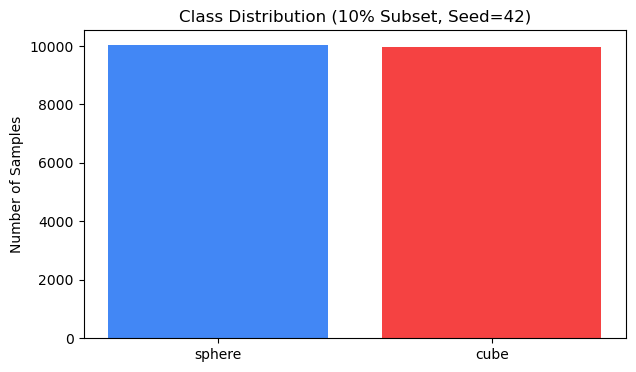

In [3]:
F = fe.ViewField

# Clear old tags if any (important if re-running the cell)
dataset.untag_samples(["train", "val"])

print("="*50)
print(f"DATASET REPORT: {fiftyone_dataset_name}")
print("="*50)

# Overall Counts
print(f"Total samples (all slices): {len(dataset)}")
print(f"Total grouped pairs: {len(dataset.select_group_slices('rgb'))}")

# Modality Specific Statistics
for slice_name in dataset.group_slices:
    view = dataset.select_group_slices(slice_name)
    counts = view.count_values("ground_truth.label")
    
    print(f"\nModality: {slice_name.upper()}")
    print(f" - Count: {len(view)}")
    print(f" - Classes: {counts}")
    
    # Get metadata for one sample (Dimensions & Type)
    sample = view.first()
    try:
        with Image.open(sample.filepath) as img:
            print(f" - Dimensions: {img.size} (Width x Height)")
            print(f" - Data Type: {img.mode}")
    except:
        print(" - Metadata: Unable to read file (check mount)")

# Train/Validation Split (80/20)
# Get unique stems in the subset
subset_stems = list(set(Path(rgb_s.filepath).stem for rgb_s, lidar_s in subset))

# Split the stems list 
random.seed(SEED)
random.shuffle(subset_stems)
split_idx = int(len(subset_stems) * 0.5)

train_stems = set(subset_stems[:split_idx])
val_stems = set(subset_stems[split_idx:])

# Prepare and Tag the samples
final_samples = []
for rgb_s, lidar_s in subset:
    stem = Path(rgb_s.filepath).stem
    
    # Assign tag based on which stem set it belongs to
    tag = "train" if stem in train_stems else "val"
    
    rgb_s.tags.append(tag)
    lidar_s.tags.append(tag)
    final_samples.extend([rgb_s, lidar_s])

dataset.add_samples(final_samples) # Add to FiftyOne dataset

train_ids = sorted(list(train_stems))
val_ids = sorted(list(val_stems))
train_count = len(list(train_stems))
val_count = len(list(val_stems))

# Verify no overlap between training and validation splits
intersect = set(train_ids).intersection(set(val_ids))
if len(intersect) > 0:
    raise ValueError(f"Overlapping IDs between train and val splits: {intersect}")
else:
    # Save as a dictionary
    split_data = {
        "train": train_ids,
        "val": val_ids,
        "seed": SEED,
        "subset_percentage": 0.10
    }

    mapping_file = "subset_splits.json"
    with open(f"{MOUNTED_ROOT_PATH}/{mapping_file}", "w") as f:
        json.dump(split_data, f, indent=4)

    print(f"✅ Saved split to {mapping_file}")
    print(f"   - Train samples: {len(train_ids)}")
    print(f"   - Val samples: {len(val_ids)}")

    print(f"\nSplit sizes (on pairs):")
    print(f" - Train: {train_count}")
    print(f" - Validation: {val_count}")

print(f"\nSample fields:")
for field_name, field in dataset.get_field_schema().items():
    print(f"  - {field_name}: {field}")
print("="*60)

# Class Distribution Visualization
rgb_counts = dataset.select_group_slices("rgb").count_values("ground_truth.label")
plt.figure(figsize=(7, 4))
plt.bar(rgb_counts.keys(), rgb_counts.values(), color=['#4287f5', '#f54242'])
plt.title(f"Class Distribution (10% Subset, Seed={SEED})")
plt.ylabel("Number of Samples")
plt.show()

### Requirement 2.3 (Visual Exploration)

In [4]:
# Launch the App
session = fo.launch_app(dataset)

# Requirements 2.3 Documentation Helper
print("\n" + "="*60)
print("ACTION REQUIRED FOR REQUIREMENT 2.3:")
print("="*60)
print("1. If the cell below is blank, check the 'PORTS' tab in VS Code.")
print("2. Ensure port 5151 is forwarded to 127.0.0.1:5151.")
print(f"3. Open this link in your LOCAL browser: http://127.0.0.1:5151")
print("4. IN THE APP: Click the 'Group' icon in the top bar to see RGB and LiDAR side-by-side.")
print("="*60)


ACTION REQUIRED FOR REQUIREMENT 2.3:
1. If the cell below is blank, check the 'PORTS' tab in VS Code.
2. Ensure port 5151 is forwarded to 127.0.0.1:5151.
3. Open this link in your LOCAL browser: http://127.0.0.1:5151
4. IN THE APP: Click the 'Group' icon in the top bar to see RGB and LiDAR side-by-side.


In [5]:
################################
# Sanity Checks for the App
################################

# Verify the path of the first sample
sample = dataset.first()
print(f"Checking file: {sample.filepath}")

if os.path.exists(sample.filepath):
    print("✅ File exists and is reachable!")
else:
    print("❌ FILE NOT FOUND! The path in the dataset is incorrect.")
    # If this fails, we need to fix the MOUNTED_PATH logic 

# Compute Metadata 
print("Computing metadata for the grid view... (this may take a minute)")
dataset.compute_metadata()

print("✅ Metadata computed. Now try launching the app again.")

Checking file: /home/vanessa/Documents/repos/BuildingAIAgentsWithMultimodalModels/data/assessment/cubes/rgb/9916.png
✅ File exists and is reachable!
Computing metadata for the grid view... (this may take a minute)
Computing metadata...
 100% |███████████████| 3998/3998 [4.0s elapsed, 0s remaining, 1.0K samples/s]         
✅ Metadata computed. Now try launching the app again.



Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds

